In [269]:
from PIL import Image
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [270]:
original_pil = Image.open("placa real.jpg")
gray_pil = original_pil.convert("L")
gray = np.array(gray_pil)

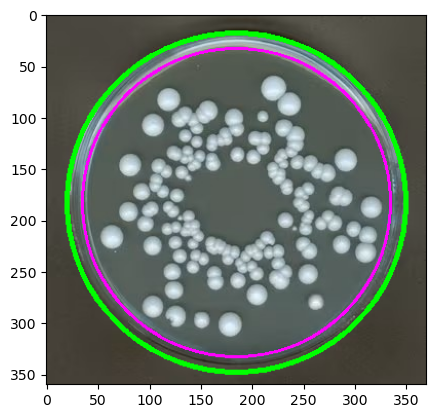

In [271]:
gray_blur = cv2.GaussianBlur(gray, (9, 9), 2)

circles = cv2.HoughCircles(
    gray_blur,
    cv2.HOUGH_GRADIENT,
    dp=1.2,
    minDist=100,
    param1=100,
    param2=30,
    minRadius=100,
    maxRadius=210
)

frame = cv2.cvtColor(np.array(Image.open("placa real.jpg")), cv2.COLOR_RGB2BGR)

if circles is not None:
    circles = np.round(circles[0, :]).astype("int")
    circles = sorted(circles, key=lambda x: x[2], reverse=True)

    x, y, r = circles[0]
    cv2.circle(frame, (x, y), r, (0, 255, 0), 4)
    n = 15  
    r_reduced = max(1, r - n) 
    cv2.circle(frame, (x, y), r_reduced, (255, 0, 255), 2)

    mask = np.zeros_like(gray)

    cv2.circle(mask, (x, y), r_reduced, (255, 255, 255), -1)
    

    masked = cv2.bitwise_and(gray, mask)

plt.imshow(frame)

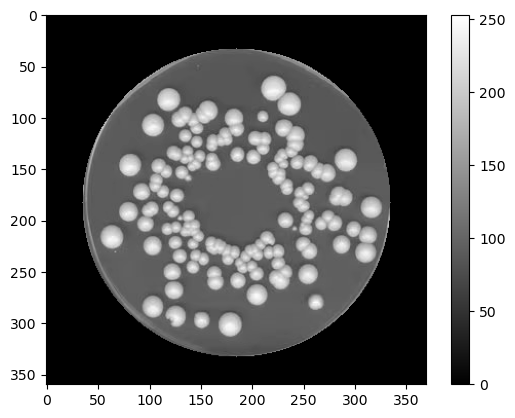

In [272]:
plt.imshow(masked,cmap='gray')
plt.colorbar()

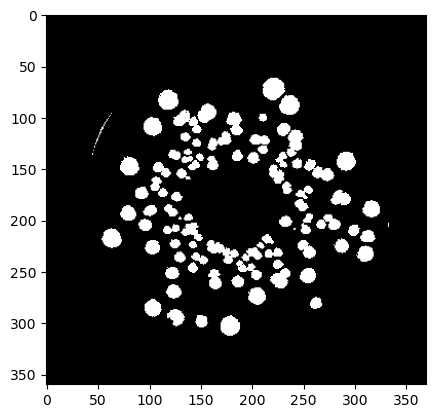

In [273]:
filtro = masked>180
plt.imshow(filtro,cmap='gray')

In [274]:
np.count_nonzero(filtro)/np.count_nonzero(masked)

0.17498337601335578

In [275]:
import numpy as np
from sklearn.linear_model import LinearRegression

masked_gray = masked.copy()

ys, xs = np.where(masked_gray > 0)  
intensities = masked_gray[ys, xs]   

X = np.column_stack((xs, ys))  
y = intensities                

model = LinearRegression().fit(X, y)

a, b = model.coef_
c = model.intercept_

print(f"Gradiente x (a): {a:.4f}")
print(f"Gradiente y (b): {b:.4f}")
print(f"Intercepto (c): {c:.4f}")


Gradiente x (a): -0.0051
Gradiente y (b): 0.0226
Intercepto (c): 116.4646


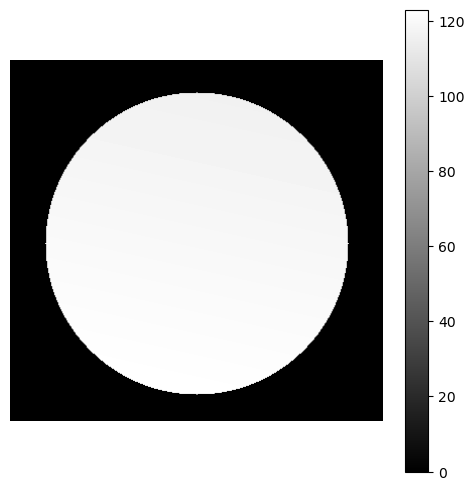

In [276]:

gradient_image = np.zeros_like(masked_gray, dtype=np.float32)

for x, y in zip(xs, ys):
    gradient_image[y, x] = a * x + b * y + c  

plt.figure(figsize=(6, 6))
plt.imshow(gradient_image, cmap='gray')
plt.colorbar()
plt.axis('off')
plt.show()


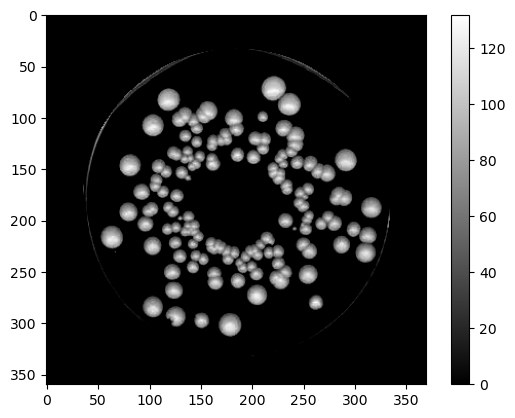

In [277]:
sem_luz = masked-gradient_image
cv2.circle(mask, (x, y), r_reduced, (255, 255, 255), -1)
sem_luz_uint8 = np.clip(sem_luz, 0, 255).astype(np.uint8)
sem_luz_norm = cv2.bitwise_and(sem_luz_uint8, mask)


plt.imshow(sem_luz_norm,cmap='gray')
plt.colorbar()


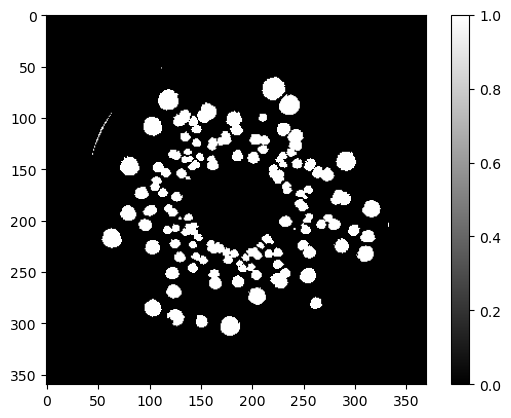

In [282]:
filtro = sem_luz>60
plt.imshow(filtro,cmap='gray')
plt.colorbar()


In [283]:
np.count_nonzero(filtro)/np.count_nonzero(masked)

0.17788373113000666

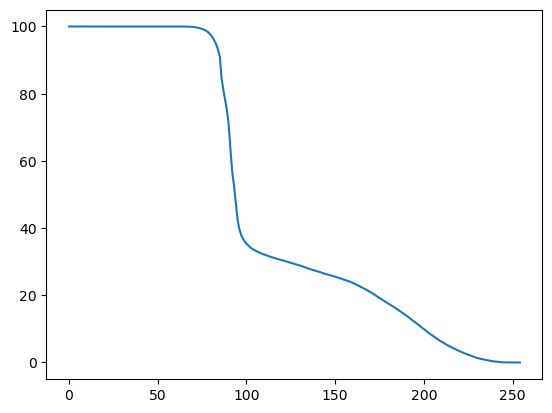

In [280]:
porcentagens = []
valor_i = []

for i in range(0,255):
   filtro = masked>i
   porcentagens.append((np.count_nonzero(filtro)/np.count_nonzero(masked))*100)
   valor_i.append(i)
   
plt.plot(valor_i,porcentagens)

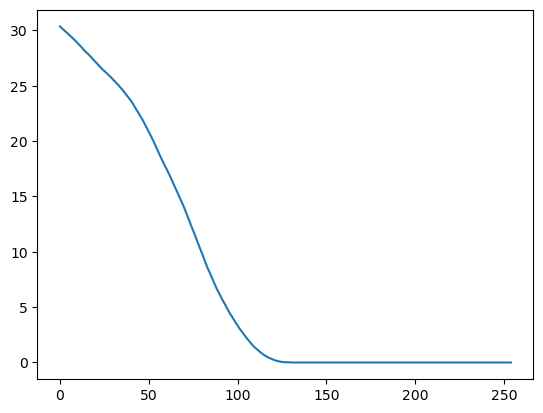

In [281]:
porcentagens = []
valor_i = []

for i in range(0,255):
   filtro =sem_luz_norm>i
   porcentagens.append((np.count_nonzero(filtro)/np.count_nonzero(masked))*100)
   valor_i.append(i)

plt.plot(valor_i,porcentagens)